# Scan analysis - shap

Calculates shap values.

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import itertools

import seaborn as sns


from matplotlib.colors import BoundaryNorm

import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

import shap


from plots2.fns import (
    get_corner_annotations,
    get_dose_colors
)


from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE,
)

from poly2.utils import (
    object_load, 
    get_best_dose_for_cb
)
from poly2.config import Config

from poly2.run import get_data_from_pars

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
df = pd.read_csv('../outputs/combined/processed_scan_all.csv')

# Load SHAP values

In [4]:
shap_values = object_load('../outputs/SHAP/all.pickle')

# Fig 4

In [5]:
HEIGHT = 4
WIDTH = 6

MAX_DISPLAY = 8

In [6]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

## Get line plot data (A)

In [7]:
pars = (
    df
    .loc[lambda x: x.run==0]
    .head(1)
    .drop(['best_dose', 'year', 'run'], axis=1)
)

pars

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.397237


In [8]:
pars.round(4)

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,17.8797,2.7441,0.6028,1.7864,0.7036,1.9579,0.3972


Below cell takes around `4.5 minutes`

In [9]:
%%time
line_df = get_data_from_pars(pars)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:24<00:00, 26.43s/it]

Wall time: 4min 24s


In [12]:
line_df.head()

,dose,yld,fung_mean,year
0,0.1,NaN,0.001667,0
1,0.1,9.179550,0.001672,1
2,0.1,9.179542,0.001679,2
3,0.1,9.179532,0.001687,3
4,0.1,9.179520,0.001698,4


In [16]:
bd_use = get_best_dose_for_cb(line_df, 10.15, 0.3)

## Setup

In [17]:
WIDTH_A_B = 6
WIDTH_C_D = 6

In [18]:
A_B_fig_loc = [0, 0, 0.9, 0.88]
C_D_loc = [0, 0, 1, 0.95]
# annot_pos = (0.09, 0.94)
annot_pos = (0.09, 0.92)

## A

Text(0.09, 0.92, 'A')

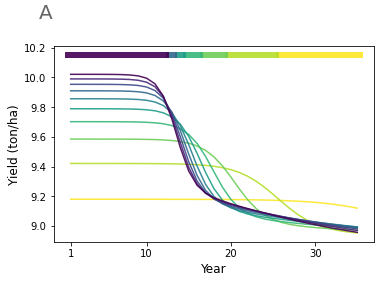

In [66]:
f, ax = plt.subplots()

alpha_A = 0.9

COLZ = get_dose_colors()

for ind, dose in enumerate(line_df.dose.unique()):
    n_d = len(line_df.dose.unique())
        
    colr = COLZ[ind]
    
    ax.plot(line_df.loc[lambda x: x.dose==dose].year,
            line_df.loc[lambda x: x.dose==dose].yld,
            alpha=alpha_A,
            c=colr)
    
    ax.plot(bd_use.loc[lambda x: x.dose==dose].year,
            bd_use.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha_A,
            lw=6)

f.set_figwidth(WIDTH_A_B)
f.set_figheight(HEIGHT)

f.patch.set_facecolor('white')

ax.set_xlabel('Year')
ax.set_ylabel('Yield (ton/ha)')

ax.set_xticks([1,10,20,30])
ax.set_xticklabels([1,10,20,30], rotation=0)



f.tight_layout(rect=A_B_fig_loc)

plt.annotate(
    'A',
    annot_pos,
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# f

In [67]:
f.savefig('../figures/to_combine/fig4_1.jpg', dpi=1200) #, bbox_inches="tight")

## C

In [29]:
shap_values[[0,20], "year"].values

array([ 0.32527554, -0.13971725], dtype=float32)

Text(0.09, 0.92, 'C')

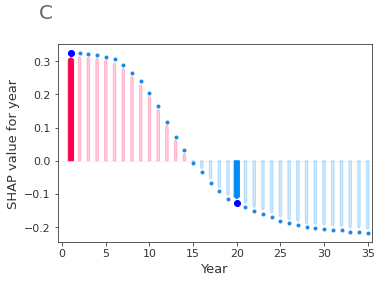

In [33]:
plt.close('all')

shap.plots.scatter(
    shap_values[1:35, "year"], 
    # color=shap_values,
    hist=False,
    show=False,
)

f = plt.gcf()

ax = plt.gca()

f.patch.set_facecolor('white')

ax.plot([-1, 36], [0,0], c='grey', alpha=0.1, lw=1)

dy = 0.01
dybig = 0.014

plt.arrow(
    shap_values[0, "year"].data,
    0,
    0, 
    shap_values[0, "year"].values - dybig,
    length_includes_head=True,
    head_width=0.6,
    head_length=0.006,
    width=0.6,
    color=(1,0,80/255),
)

plt.arrow(
    shap_values[19, "year"].data,
    0,
    0, 
    shap_values[19, "year"].values + dybig,
    length_includes_head=True,
    head_width=0.6,
    head_length=0.006,
    width=0.6,
    color=(0,139/255,250/255),
)


for year in np.arange(2,36):
    
    if year==20:
        continue
    
    if shap_values[year-1, "year"].values>0:
        eps = -dy
        col = (1,0,80/255)
    else:
        eps = +dy
        col = (0,139/255,250/255)
    
    if abs(shap_values[year-1, "year"].values) < abs(eps):
        eps=0

    plt.arrow(
        shap_values[year-1, "year"].data,
        0,
        0, 
        shap_values[year-1, "year"].values+eps,
        length_includes_head=True,
        head_width=0.3,
        head_length=0.005,
        width=0.3,
        alpha=0.2,
        color=col,
    )

ax.scatter(shap_values[0, "year"].data, shap_values[0, "year"].values, c='b')
ax.scatter(shap_values[19, "year"].data, shap_values[19, "year"].values, c='b')

ax.set_xlabel('Year')
ax.set_ylabel('SHAP value for year')
ax.set_xlim([-0.5, 35.5])

# ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.325])
# ax.set_yticklabels([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.33])

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


f.set_figwidth(WIDTH_A_B)
f.set_figheight(HEIGHT)

f.tight_layout(rect=A_B_fig_loc)

plt.annotate(
    'C',
    annot_pos,
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# print(pos1)

# f

In [34]:
f.savefig('../figures/to_combine/fig4_3.jpg', dpi=1200) #, bbox_inches="tight")

## B

Text(0.09, 0.92, 'B')

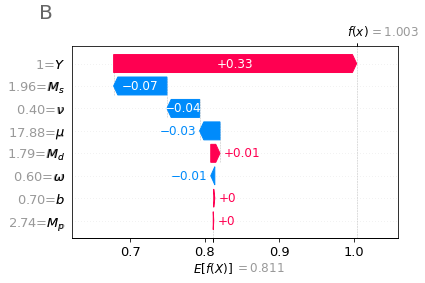

In [56]:
plt.close('all')

shap.plots.waterfall(
    shap_values[0],
    max_display=MAX_DISPLAY,
    show=False,
)

f = plt.gcf()
ax = plt.gca()


f.patch.set_facecolor('white')

ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


labels=[
    r'$M_p$',
    r'$b$',
    r'$\omega$',
    r'$M_d$',
    r'$\mu$',
    r'$\nu$',
    r'$M_s$',
    r'$Y$',
]*2

names=[
    'b',
    'm_prop',
    'asymp',
    'dec_rate',
    'mu',
    'ME_mean',
    'm_scale',
    'year',
]*2

ticklabels = [
    f'{shap_values[0, names[ii]].data:.2f}={labels[ii]}'
    if ii <8 else
    f'{labels[ii-8]}'
    # for ii in range(8)
    for ii in range(16)
]

labs2 = [f'{shap_values[0, "year"].data:.0f}=$Y$' if '$Y$' in x else x for x in ticklabels]
labs3 = [f'$Y$' if ('$Y$' in x and ind>8) else x for ind, x in enumerate(labs2)]

ax.set_yticklabels(labs3)



f.set_figwidth(WIDTH_C_D)
f.set_figheight(HEIGHT)

f.tight_layout(rect=C_D_loc)

plt.annotate(
    'B',
    annot_pos,
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# f

In [57]:
f.savefig('../figures/to_combine/fig4_2.jpg', dpi=1200) #, bbox_inches="tight")

## D

Text(0.09, 0.92, 'D')

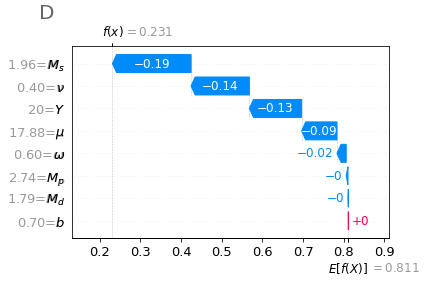

In [53]:
plt.close('all')

shap.plots.waterfall(
    shap_values[19],
    max_display=MAX_DISPLAY,
    show=False,
)

f = plt.gcf()
ax = plt.gca()


f.patch.set_facecolor('white')

ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


labels=[
    r'$b$',
    r'$M_d$',
    r'$M_p$',
    r'$\omega$',
    r'$\mu$',
    r'$Y$',
    r'$\nu$',
    r'$M_s$',
]*2

names=[
    'm_prop',
    'dec_rate',
    'b',
    'asymp',
    'mu',
    'year',
    'ME_mean',
    'm_scale',
]*2

ticklabels = [
    f'{shap_values[19, names[ii]].data:.2f}={labels[ii]}'
    if ii <8 else
    f'{labels[ii-8]}'
    # for ii in range(8)
    for ii in range(16)
]
labs2 = [f'{shap_values[19, "year"].data:.0f}=$Y$' if '$Y$' in x else x for x in ticklabels]
labs3 = [f'$Y$' if ('$Y$' in x and ind>8) else x for ind, x in enumerate(labs2)]

ax.set_yticklabels(labs3)


f.set_figwidth(WIDTH_C_D)
f.set_figheight(HEIGHT)

f.tight_layout(rect=C_D_loc)

plt.annotate(
    'D',
    annot_pos,
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# f

In [54]:
f.savefig('../figures/to_combine/fig4_4.jpg', dpi=1200) #, bbox_inches="tight")

### Combine panels using 'magick'

e.g.:
```
magick montage fig5_[1-2].jpg -geometry XXxYY+dx+dy output.jpg
```

Other options:

On top of each other (2 rows)
```
magick montage fig5_[1-2].jpg -tile x2 -geometry XXxYY+dx+dy output.jpg
```
Next to each other (2 cols)
```
magick montage fig5_[1-2].jpg -tile 2x -geometry XXxYY+dx+dy output.jpg
```

### Command to use
Run this in `cmd`:
```
cd Documents\Python\PhD\poly2\polygenic2\figures\to_combine
magick montage fig4_[1-4].jpg -geometry 1000x700+1+10 fig4.jpg
```

# Fig 5

In [39]:
WIDTH = 8
HEIGHT = 4

## A

Text(0.05, 0.9, 'A')

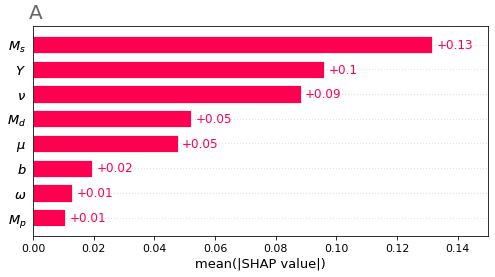

In [68]:
plt.close('all')

shap.plots.bar(shap_values, show=False)

f = plt.gcf()

ax = plt.gca()

f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.patch.set_facecolor('white')


labels=[
    r'$M_s$',
    r'$Y$',
    r'$\nu$',
    r'$M_d$',
    r'$\mu$',
    r'$b$',
    r'$\omega$',
    r'$M_p$',
]*2

ax.set_yticklabels(labels)


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.set_xlim([0, 0.15])

f.tight_layout(rect=[0.028, 0, 0.9, 0.92])

plt.annotate(
    'A',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# f

In [69]:
f.savefig('../figures/to_combine/fig5_1.jpg', dpi=1200)

## B

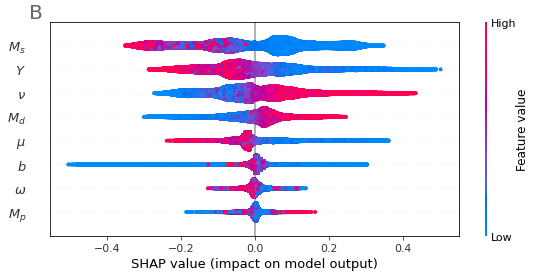

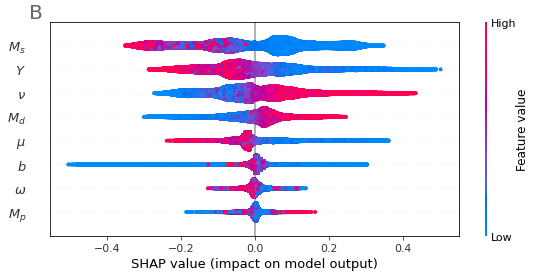

In [48]:
plt.close('all')

shap.plots.beeswarm(shap_values, plot_size=(WIDTH,HEIGHT), show=False)

f = plt.gcf()

ax = plt.gca()

f.patch.set_facecolor('white')


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

labels=[
    r'$M_p$',
    r'$\omega$',
    r'$b$',
    r'$\mu$',
    r'$M_d$',
    r'$\nu$',
    r'$Y$',
    r'$M_s$',
]

ax.set_yticklabels(labels)


f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'B',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

f

In [49]:
f.savefig('../figures/to_combine/fig5_2.jpg', dpi=1200) # , bbox_inches="tight"

Run this in `cmd`:
```
cd Documents\Python\PhD\poly2\polygenic2\figures\to_combine
magick montage fig5_[1-2].jpg -tile x2 -geometry 1000x450+2+20 fig5.jpg
```

# Fig 6

In [58]:
cf = Config()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = None



In [59]:
# a = cf.k_mu*cf.k_b
# b = cf.k_b

# init_dist = gamma_dist(cf.n_k, a, b)


# asymptote = 1

#
# * in trait space, get mean and variance

# tv = trait_vec(cf.n_k)
# # NB get_dist_var/mean needs init_dist to be shape (n_k, n_years)
# reshaped = init_dist.reshape((cf.n_k, 1))
# tv_var = get_dist_var(reshaped, tv)[0]
# tv_mean = get_dist_mean(reshaped, tv)[0]

# NB max_effect = 1 - w + w * exp(-curv)
#               = 1 - w + w * k
# max_effect_mean = 1 - asymptote + asymptote * tv_mean
# max_effect_var = (asymptote**2) * tv_var


default_b = cf.k_b
default_mu = cf.k_mu
a = cf.k_mu * cf.k_b

max_effect_mean = (default_b/(default_b+1))**a

# ev = edge_values(10)
# dist_summary = gamma_dist(10, a, b)

In [60]:
shap_values.values.min(), shap_values.values.max()

(-0.50467753, 0.50166166)

In [61]:
ymin = -0.55
ymax = 0.55

Wall time: 15.9 s


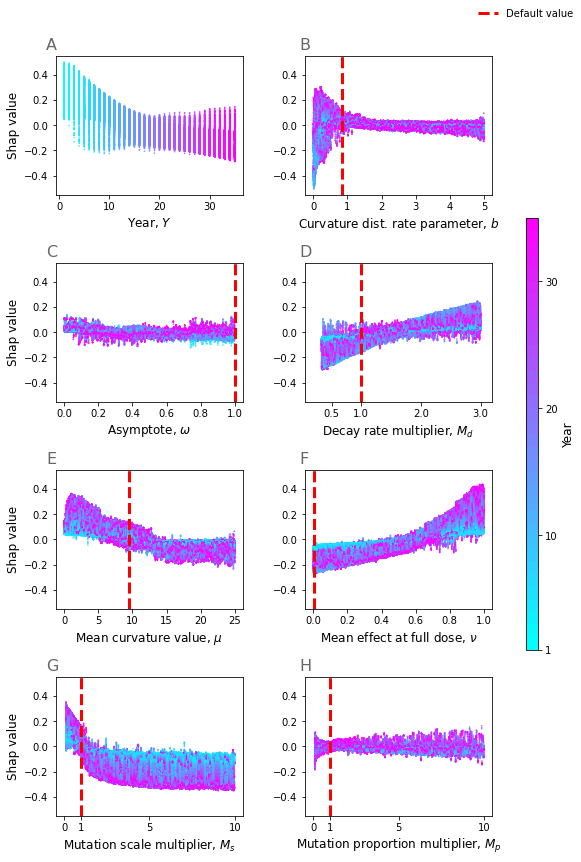

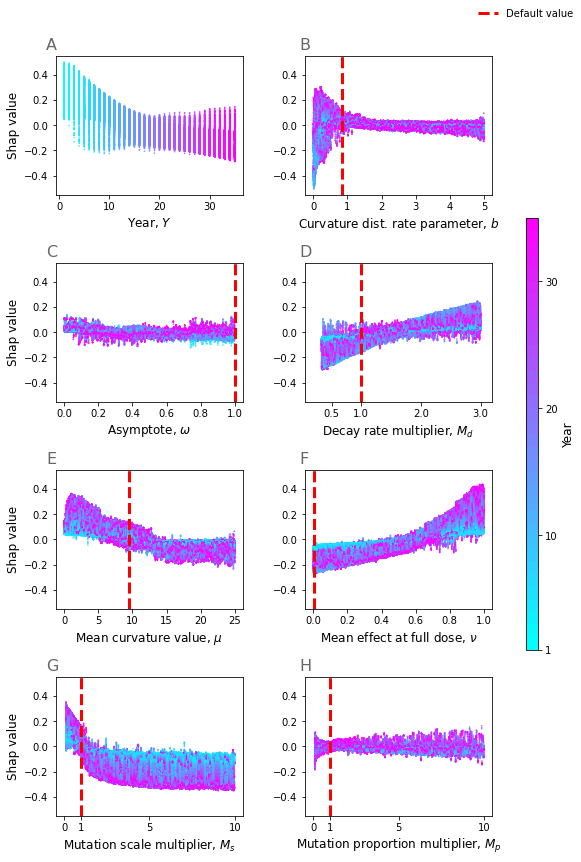

In [62]:
%%time

plt.close('all')

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title


f, ax = plt.subplots(4, 2, figsize=(8, 12))

alpha = 0.8
size = 0.4

# DATA


clrmap = plt.cm.cool  # define the colormap
cmaplist = [clrmap(i) for i in range(clrmap.N)]

cm3 = LinearSegmentedColormap.from_list("", cmaplist, clrmap.N)

bounds = np.linspace(1, 35, 35)
norm = BoundaryNorm(bounds, clrmap.N)

cmap3 = ScalarMappable(cmap=cm3, norm=norm)


colors3 = cmap3.to_rgba(shap_values[:, 'year'].data)

# A
ax[0][0].scatter(
    shap_values[:, "year"].data,
    shap_values[:, "year"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# B
ax[0][1].scatter(
    shap_values[:, "b"].data,
    shap_values[:, "b"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# C
ax[1][0].scatter(
    shap_values[:, "asymp"].data,
    shap_values[:, "asymp"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# D
ax[1][1].scatter(
    shap_values[:, "dec_rate"].data,
    shap_values[:, "dec_rate"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# E
ax[2][0].scatter(
    shap_values[:, "mu"].data,
    shap_values[:, "mu"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# F
ax[2][1].scatter(
    shap_values[:, "ME_mean"].data,
    shap_values[:, "ME_mean"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)



# G
ax[3][0].scatter(
    shap_values[:, "m_scale"].data,
    shap_values[:, "m_scale"].values,
    alpha=alpha, 
    color=colors3, 
    s=size,
)

# H
ax[3][1].scatter(
    shap_values[:, "m_prop"].data, 
    shap_values[:, "m_prop"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)




# LAYOUT

# A
ax[0][0].set_xlabel(r'Year, $Y$')


# B
ax[0][1].set_xlabel(r'Curvature dist. rate parameter, $b$')
ax[0][1].axvline(cf.k_b, color='r', label='Default value', ls='--', lw=3)


# C
ax[1][0].set_xlabel(r'Asymptote, $\omega$')
ax[1][0].set_xlim([-0.05,1.05])
ax[1][0].axvline(1, color='r', ls='--', lw=3)


# D
ax[1][1].set_xlabel(r'Decay rate multiplier, $M_d$')
ax[1][1].set_xlim([0.05, 3.2])
ax[1][1].set_xticks([0.5, 1, 2, 3])
ax[1][1].axvline(1, color='r', ls='--', lw=3)

# E
ax[2][0].set_xlabel(r'Mean curvature value, $\mu$')
ax[2][0].axvline(cf.k_mu, color='r', ls='--', lw=3)


# F
ax[2][1].set_xlabel(r'Mean effect at full dose, $\nu$')
ax[2][1].set_xlim([-0.05,1.05])
ax[2][1].axvline(max_effect_mean, color='r', ls='--', lw=3)


# G
ax[3][0].set_xlabel(r'Mutation scale multiplier, $M_s$')
ax[3][0].set_xlim([-0.5,10.5])
ax[3][0].set_xticks([0, 1, 5, 10])
ax[3][0].axvline(1, color='r', ls='--', lw=3)


# H
ax[3][1].set_xlabel(r'Mutation proportion multiplier, $M_p$')
ax[3][1].set_xlim([-0.5,10.5])
ax[3][1].set_xticks([0, 1, 5, 10])
ax[3][1].axvline(1, color='r', ls='--', lw=3)


for ii, jj in itertools.product(np.arange(4), np.arange(2)):
    ax[ii][jj].spines['top'].set_visible(True)
    ax[ii][jj].spines['right'].set_visible(True)
    

    ax[ii][jj].set_ylim([ymin, ymax])
    
    if jj==0:
        ax[ii][jj].set_ylabel('Shap value')
    else:
        ax[ii][jj].set_ylabel('')

    
    





f.patch.set_facecolor('white')

f.align_ylabels()

plt.tight_layout(rect=[0, 0, 0.88, 0.95], h_pad=3, w_pad=3)

xx = 0.92
dx = 0.02
dy = 0.3

cax3 = plt.axes([xx, 0.25, dx, 0.5])
plt.colorbar(cmap3, cax=cax3, label='Year', ticks=[1, 10, 20, 30])

get_corner_annotations(2, 4, 0.08, 0.94, 0.44, 0.2395, plt)

f.legend(
    loc=1,
    framealpha=0,
)

f

In [64]:
f.savefig('../figures/paper/fig6.jpg', dpi=1200, bbox_inches="tight")